In [10]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [2]:
IMAGE_SIZE =256
BATCH_SIZE= 32
CHANNELS=3
EPOCHS =50

In [ ]:
Import data into tensorflow dataset object

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("C:/Users/SOWNDARYA/Downloads/potato/PlantVillage",
                                                    shuffle=True,
                                                    image_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                    batch_size= BATCH_SIZE
    
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names

<AxesSubplot:ylabel='count'>

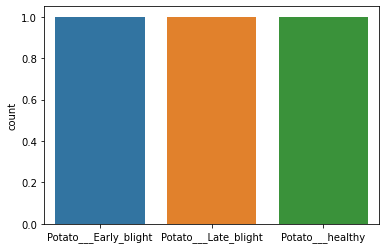

In [11]:
sns.countplot(dataset.class_names)

In [5]:
len(dataset)

68

# Visualize some of the images from our dataset

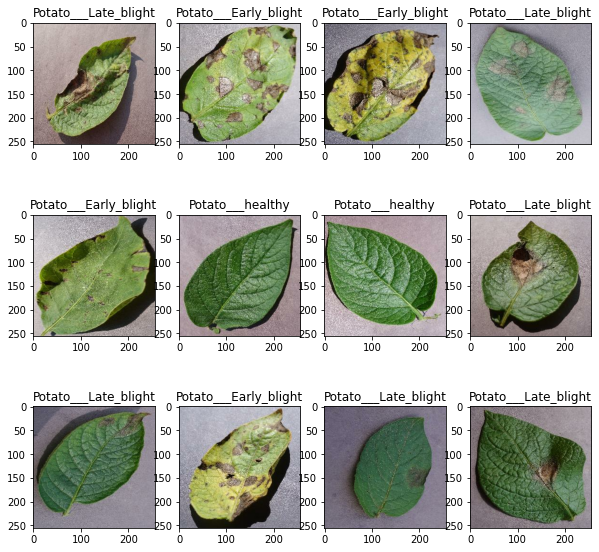

In [6]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
  for i in range(12):
     ax =plt.subplot(3,4,i+1)
     plt.imshow(image_batch[i].numpy().astype('uint8'))
     plt.title(class_names[label_batch[i]])
     

  
  
  

# Function to Split Dataset

In [7]:
len(dataset)

68

In [9]:
train_size =0.8
len(dataset)*train_size

54.400000000000006

In [10]:
train_ds = dataset.take(54)
len(train_ds)

54

In [11]:
test_ds =dataset.skip(54)
len(test_ds)

14

In [12]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [13]:
val_ds =test_ds.take(6)
len(val_ds)

6

In [14]:
test_ds =test_ds.skip(6)
len(test_ds)

8

In [15]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):

     
  
  ds_size =len(ds)

  if shuffle:

    ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split * ds_size)
    val_size=int(val_split *ds_size)

    train_ds =ds.take(train_size)
    val_ds =ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
   

    return train_ds,val_ds,test_ds





In [16]:
train_ds, val_ds, test_ds =get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

54

In [19]:
len(val_ds)

6

In [20]:
len(test_ds)

8

In [22]:
train_ds 

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# Cache, Shuffle, and Prefetch the Dataset

In [23]:
train_ds =train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds =val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds =test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Building the Model

# Creating a Layer for Resizing and Normalization

In [24]:
resize_and_rescale= tf.keras.Sequential([
     layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
     layers.experimental.preprocessing.Rescaling(1.0/255)
 ])

# Data Augmentation

Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [25]:
data_augmentation =tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

# Model Architecture

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [26]:
input_shape =(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes= 3
model =models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')

])
    
model.build(input_shape = input_shape)    


In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

# Compiling the Model

We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [28]:
 model.compile(
     optimizer ='adam',
     loss =tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
     metrics=['accuracy']
 )

In [29]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 183s 170ms/step - loss: 0.9077 - accuracy: 0.4682 - val_loss: 0.8512 - val_accuracy: 0.4740
Epoch 2/50
54/54 [==============================] - 5s 93ms/step - loss: 0.6819 - accuracy: 0.6667 - val_loss: 0.5564 - val_accuracy: 0.7031
Epoch 3/50
54/54 [==============================] - 5s 92ms/step - loss: 0.5704 - accuracy: 0.7442 - val_loss: 0.5860 - val_accuracy: 0.7292
Epoch 4/50
54/54 [==============================] - 5s 93ms/step - loss: 0.4041 - accuracy: 0.8270 - val_loss: 0.2995 - val_accuracy: 0.8750
Epoch 5/50
54/54 [==============================] - 5s 93ms/step - loss: 0.3037 - accuracy: 0.8843 - val_loss: 0.3786 - val_accuracy: 0.8333
Epoch 6/50
54/54 [==============================] - 5s 93ms/step - loss: 0.2531 - accuracy: 0.9005 - val_loss: 0.3717 - val_accuracy: 0.8594
Epoch 7/50
54/54 [==============================] - 5s 93ms/step - loss: 0.2505 - accuracy: 0.9039 - val_loss: 0.2291 - val_accuracy: 0.9115
Epoch 8/50

In [30]:
scores =model.evaluate(test_ds)

8/8 [==============================] - 4s 35ms/step - loss: 0.0372 - accuracy: 0.9883


we can see above thata we get 98.83% accuracy for our test dataset.this is considered to be a pretty good accuracy.

In [31]:
scores

[0.03717716783285141, 0.98828125]

Scores is just a list containing loss and accuracy value

# Plotting the Accuracy and Loss Curves

In [32]:
history

In [33]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [34]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [35]:
history.history['accuracy']

[0.46817129850387573,
 0.6666666865348816,
 0.7442129850387573,
 0.8269675970077515,
 0.8842592835426331,
 0.9004629850387573,
 0.9039351940155029,
 0.9276620149612427,
 0.9461805820465088,
 0.9432870149612427,
 0.9427083134651184,
 0.9513888955116272,
 0.9537037014961243,
 0.9508101940155029,
 0.9646990895271301,
 0.9675925970077515,
 0.9600694179534912,
 0.9809027910232544,
 0.9583333134651184,
 0.9791666865348816,
 0.9612268805503845,
 0.9837962985038757,
 0.9826388955116272,
 0.9820601940155029,
 0.9855324029922485,
 0.9710648059844971,
 0.9820601940155029,
 0.9849537014961243,
 0.9722222089767456,
 0.9837962985038757,
 0.9907407164573669,
 0.9947916865348816,
 0.9924768805503845,
 0.9890046119689941,
 0.9942129850387573,
 0.9953703880310059,
 0.9832175970077515,
 0.9907407164573669,
 0.9947916865348816,
 0.9930555820465088,
 0.9872685074806213,
 0.9959490895271301,
 0.9901620149612427,
 0.9809027910232544,
 0.9832175970077515,
 0.9884259104728699,
 0.9965277910232544,
 0.987268507

In [36]:
acc = history.history['accuracy']
val_acc =history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


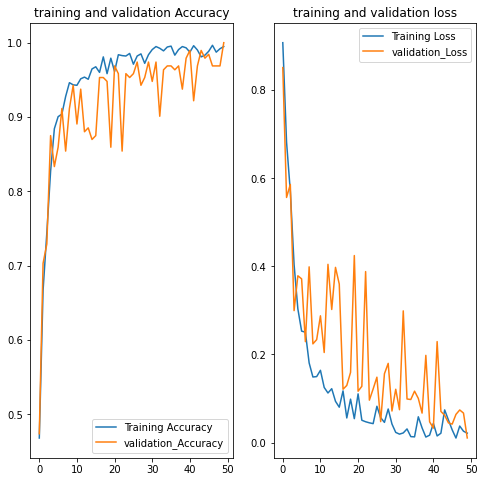

In [43]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='validation_Accuracy')
plt.legend(loc='lower right')
plt.title('training and validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='validation_Loss')
plt.legend(loc='upper right')
plt.title('training and validation loss')

plt.show()

# Run prediction on a sample image

first image to predict
actual label : Potato___Late_blight
1/1 [==============================] - 0s 30ms/step
predicted label : Potato___Late_blight


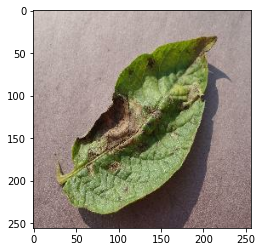

In [59]:
for images_batch,labels_batch in test_ds.take(1):
  first_image = image_batch[0].numpy().astype("uint8")
  first_label =label_batch[0].numpy()

  print('first image to predict')
  plt.imshow(first_image)
  print('actual label :',class_names[first_label])

  batch_prediction =model.predict(images_batch)
  print('predicted label :',class_names[np.argmax(batch_prediction[0])])

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 27ms/step
predicted label: Potato___Late_blight


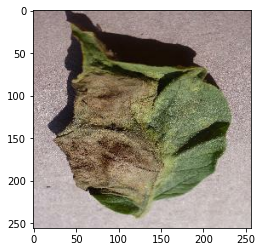

In [58]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [60]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 16ms/step


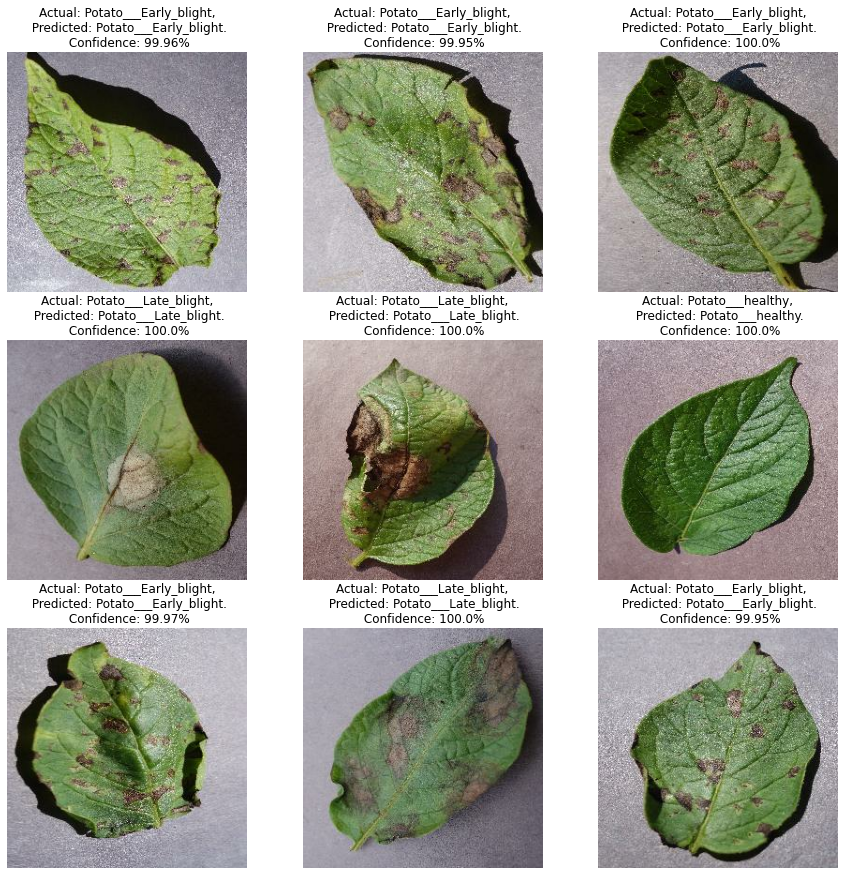

In [61]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")